In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms,models
import torchvision
from torchvision.utils import make_grid
from torch.utils.tensorboard import SummaryWriter
from IPython.display import display, clear_output

import time
import json
import numpy as np
import seaborn as sns
import pandas as pd
#from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import os
%matplotlib inline
from sklearn.metrics import confusion_matrix

from itertools import product
from collections import namedtuple
from collections import OrderedDict

CUDA = torch.cuda.is_available()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
torch.cuda.is_available()
torch.cuda.current_device()
torch.cuda.get_device_name(0)

'Tesla V100-SXM2-16GB'

In [ ]:
!unzip "/content/drive/My Drive/archive.zip"

In [ ]:
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=45),
    transforms.ToTensor(),
    transforms.Normalize([0.6768, 0.5580, 0.4836],[0.3034, 0.3600, 0.3914]),

])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.6768, 0.5580, 0.4836],[0.3034, 0.3600, 0.3914]),
])

In [5]:
train_dataset = datasets.ImageFolder(
    'fruits-360/Training',
    transform=train_transform
)

test_dataset = datasets.ImageFolder(
    'fruits-360/Test',
    transform=test_transform
)

trainloader = DataLoader(train_dataset,shuffle=True,batch_size=128)
testloader = DataLoader(test_dataset,shuffle=False,batch_size=128)

In [6]:
# imgs = torch.stack([img for img, _ in train_dataset],dim=3)

# print(imgs.view(3,-1).mean(dim=1))
# print(imgs.view(3,-1).std(dim=1))

In [7]:
print(len(train_dataset))
print(len(test_dataset))

67692
22688


In [8]:
inputs, classes = next(iter(trainloader))
print(inputs.shape)

class_names = dict((i, v) for i, v in enumerate(train_dataset.classes))
print(len(class_names))

torch.Size([128, 3, 100, 100])
131


In [9]:
class_names = train_dataset.classes
print(class_names)


['Apple Braeburn', 'Apple Crimson Snow', 'Apple Golden 1', 'Apple Golden 2', 'Apple Golden 3', 'Apple Granny Smith', 'Apple Pink Lady', 'Apple Red 1', 'Apple Red 2', 'Apple Red 3', 'Apple Red Delicious', 'Apple Red Yellow 1', 'Apple Red Yellow 2', 'Apricot', 'Avocado', 'Avocado ripe', 'Banana', 'Banana Lady Finger', 'Banana Red', 'Beetroot', 'Blueberry', 'Cactus fruit', 'Cantaloupe 1', 'Cantaloupe 2', 'Carambula', 'Cauliflower', 'Cherry 1', 'Cherry 2', 'Cherry Rainier', 'Cherry Wax Black', 'Cherry Wax Red', 'Cherry Wax Yellow', 'Chestnut', 'Clementine', 'Cocos', 'Corn', 'Corn Husk', 'Cucumber Ripe', 'Cucumber Ripe 2', 'Dates', 'Eggplant', 'Fig', 'Ginger Root', 'Granadilla', 'Grape Blue', 'Grape Pink', 'Grape White', 'Grape White 2', 'Grape White 3', 'Grape White 4', 'Grapefruit Pink', 'Grapefruit White', 'Guava', 'Hazelnut', 'Huckleberry', 'Kaki', 'Kiwi', 'Kohlrabi', 'Kumquats', 'Lemon', 'Lemon Meyer', 'Limes', 'Lychee', 'Mandarine', 'Mango', 'Mango Red', 'Mangostan', 'Maracuja', 'Melo

AttributeError: ignored

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


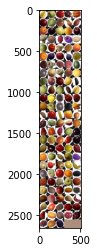

In [12]:
for images, labels in trainloader:
    break

im = make_grid(images,nrow=5)

inv_normalize = transforms.Normalize(
    mean=[-0.6768/0.3034, -0.5580/0.3600, -0.4836/0.3914],
    std = [1/0.3034,1/0.3600,1/0.3914]
)

im_inv = inv_normalize(im)

plt.figure(figsize=(12,4))
plt.imshow(np.transpose(im_inv.numpy(), (1,2,0)))

In [13]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        self.conv1 = nn.Conv2d(3,6,3,1)
        self.conv2 = nn.Conv2d(6,16,3,1)
        
        self.fc1 = nn.Linear(23*23*16,1024)
        self.fc2 = nn.Linear(1024,256)
        self.fc3 = nn.Linear(256,131)
        

    def forward(self,X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X,2,2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X,2,2)
        
        X = X.view(-1,23*23*16)
        X = F.relu(self.fc1(X))
        X = F.dropout(X, 0.2)
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        return F.log_softmax(X,dim=1)


In [14]:
CNNmodel = CNN()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(CNNmodel.parameters(),lr=0.0001)

In [15]:
model = CNNmodel.cuda()

In [16]:
num_epochs = 20

train_loss = []
test_loss = []
train_accuracy = []
test_accuracy = []

for epoch in range(num_epochs):
    #Training
    correct = 0
    iterations = 0
    iter_loss = 0.0
    
    model.train()
    
    for i, (inputs,labels) in enumerate(trainloader):
        if CUDA:
            inputs = inputs.cuda()
            labels = labels.cuda()
            
        outputs = model(inputs)
        loss = criterion(outputs,labels)
        iter_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        _,predicted = torch.max(outputs,1)
        correct += (predicted == labels).sum()
        iterations += 1
        
    train_loss.append(iter_loss/iterations)
    train_accuracy.append((100*correct // len(train_dataset)))
    
    #Testing
    testing_loss = 0.0
    correct = 0
    iterations = 0
    
    model.eval()
    
    for i, (inputs,labels) in enumerate(testloader):
        if CUDA:
            inputs = inputs.cuda()
            labels = labels.cuda()
            
        outputs = model(inputs)
        loss = criterion(outputs,labels)
        testing_loss += loss.item()
        
        _,predicted = torch.max(outputs,1)
        correct += (predicted == labels).sum()
        iterations += 1
    
    # Record the Testing loss
    test_loss.append(testing_loss/iterations)
    # Record the Testing accuracy
    test_accuracy.append((100 * correct // len(test_dataset)))
    
    print ('Epoch {}/{}, Training Loss: {:.3f}, Training Accuracy: {:.3f}, Testing Loss: {:.3f}, Testing Acc: {:.3f}'
           .format(epoch+1, num_epochs, train_loss[-1], train_accuracy[-1], 
             test_loss[-1], test_accuracy[-1]))

Epoch 1/20, Training Loss: 2.318, Training Accuracy: 40.000, Testing Loss: 1.508, Testing Acc: 60.000
Epoch 2/20, Training Loss: 0.757, Training Accuracy: 77.000, Testing Loss: 0.895, Testing Acc: 75.000
Epoch 3/20, Training Loss: 0.381, Training Accuracy: 88.000, Testing Loss: 0.662, Testing Acc: 82.000
Epoch 4/20, Training Loss: 0.233, Training Accuracy: 92.000, Testing Loss: 0.518, Testing Acc: 86.000
Epoch 5/20, Training Loss: 0.166, Training Accuracy: 94.000, Testing Loss: 0.492, Testing Acc: 87.000
Epoch 6/20, Training Loss: 0.121, Training Accuracy: 96.000, Testing Loss: 0.457, Testing Acc: 88.000
Epoch 7/20, Training Loss: 0.095, Training Accuracy: 96.000, Testing Loss: 0.417, Testing Acc: 90.000
Epoch 8/20, Training Loss: 0.079, Training Accuracy: 97.000, Testing Loss: 0.389, Testing Acc: 90.000
Epoch 9/20, Training Loss: 0.066, Training Accuracy: 97.000, Testing Loss: 0.413, Testing Acc: 91.000
Epoch 10/20, Training Loss: 0.059, Training Accuracy: 98.000, Testing Loss: 0.415,

In [ ]:
plt.plot(train_loss, label='train loss')
plt.plot(test_loss, label='test loss')
plt.legend()
plt.show()

In [25]:
torch.save(model,'fruitygooglecolab_runman2.pt')

In [20]:
test_load_all = DataLoader(test_dataset, batch_size=22668, shuffle=False)
with torch.no_grad():
    correct = 0
    for X_test, y_test in test_load_all:
        
        if CUDA:
            X_test = X_test.cuda()
            y_test = y_test.cuda()
        
        y_val = model(X_test)  # we don't flatten the data this time
        predicted = torch.max(y_val,1)[1]
        correct += (predicted == y_test).sum()
print(f'Test accuracy: {correct.item()}/{len(test_dataset)} = {correct.item()*100/(len(test_dataset)):7.3f}%')

Test accuracy: 21324/22688 =  93.988%


In [23]:
params = OrderedDict(
    lr = [0.001,0.0001],
    batch_size = [64,128]
)

epochs=5
runs = RunBuilder.get_runs(params)

In [22]:
class RunBuilder():
  @staticmethod
  def get_runs(params):

    Run = namedtuple('Run', params.keys())

    runs = []
    for v in product(*params.values()):
      runs.append(Run(*v))
    
    return runs

class RunManager():
  def __init__(self):

    # tracking every epoch count, loss, accuracy, time
    self.epoch_count = 0
    self.epoch_loss = 0
    self.epoch_num_correct = 0
    self.epoch_start_time = None

    # tracking every run count, run data, hyper-params used, time
    self.run_params = None
    self.run_count = 0
    self.run_data = []
    self.run_start_time = None

    # record model, loader and TensorBoard 
    self.network = None
    self.loader = None
    self.tb = None

  # record the count, hyper-param, model, loader of each run
  # record sample images and network graph to TensorBoard  
  def begin_run(self, run, network, loader):

    self.run_start_time = time.time()

    self.run_params = run
    self.run_count += 1

    self.network = network
    self.loader = loader
    self.tb = SummaryWriter(comment=f'-{run}')

    images, labels = next(iter(self.loader))
    grid = torchvision.utils.make_grid(images)

    self.tb.add_image('images', grid)
    self.tb.add_graph(self.network, images.cuda())

  # when run ends, close TensorBoard, zero epoch count
  def end_run(self):
    self.tb.close()
    self.epoch_count = 0

  # zero epoch count, loss, accuracy, 
  def begin_epoch(self):
    self.epoch_start_time = time.time()

    self.epoch_count += 1
    self.epoch_loss = 0
    self.epoch_num_correct = 0

  # 
  def end_epoch(self):
    # calculate epoch duration and run duration(accumulate)
    epoch_duration = time.time() - self.epoch_start_time
    run_duration = time.time() - self.run_start_time

    # record epoch loss and accuracy
    loss = self.epoch_loss / len(self.loader.dataset)
    accuracy = self.epoch_num_correct / len(self.loader.dataset)

    # Record epoch loss and accuracy to TensorBoard 
    self.tb.add_scalar('Loss', loss, self.epoch_count)
    self.tb.add_scalar('Accuracy', accuracy, self.epoch_count)

    # Record params to TensorBoard
    for name, param in self.network.named_parameters():
      self.tb.add_histogram(name, param, self.epoch_count)
      self.tb.add_histogram(f'{name}.grad', param.grad, self.epoch_count)
    
    # Write into 'results' (OrderedDict) for all run related data
    results = OrderedDict()
    results["run"] = self.run_count
    results["epoch"] = self.epoch_count
    results["loss"] = loss
    results["accuracy"] = accuracy
    results["epoch duration"] = epoch_duration
    results["run duration"] = run_duration

    # Record hyper-params into 'results'
    for k,v in self.run_params._asdict().items(): results[k] = v
    self.run_data.append(results)
    df = pd.DataFrame.from_dict(self.run_data, orient = 'columns')

    # display epoch information and show progress
    clear_output(wait=True)
    display(df)

  # accumulate loss of batch into entire epoch loss
  def track_loss(self, loss):
    # multiply batch size so variety of batch sizes can be compared
    self.epoch_loss += loss.item() * self.loader.batch_size

  # accumulate number of corrects of batch into entire epoch num_correct
  def track_num_correct(self, preds, labels):
    self.epoch_num_correct += self._get_num_correct(preds, labels)

  @torch.no_grad()
  def _get_num_correct(self, preds, labels):
    return preds.argmax(dim=1).eq(labels).sum().item()
  
  # save end results of all runs into csv, json for further analysis
  def save(self, fileName):

    pd.DataFrame.from_dict(
        self.run_data, 
        orient = 'columns',
    ).to_csv(f'{fileName}.csv')

    with open(f'{fileName}.json', 'w', encoding='utf-8') as f:
      json.dump(self.run_data, f, ensure_ascii=False, indent=4)

In [24]:
m = RunManager()

# get all runs from params using RunBuilder class
for run in RunBuilder.get_runs(params):

    # if params changes, following line of code should reflect the changes too
    network = CNN().cuda()
    loader = torch.utils.data.DataLoader(train_dataset, batch_size = run.batch_size)
    optimizer = torch.optim.Adam(network.parameters(), lr=run.lr)

    m.begin_run(run, network, loader)
    for epoch in range(epochs):
      
      m.begin_epoch()
      for batch in loader:
        
        images = batch[0].cuda()
        labels = batch[1].cuda()
        preds = network(images)
        loss = F.cross_entropy(preds, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        m.track_loss(loss)
        m.track_num_correct(preds, labels)

      m.end_epoch()
    m.end_run()

# when all runs are done, save results to files
m.save('results2')

,run,epoch,loss,accuracy,epoch duration,run duration,lr,batch_size
0,1,1,5.117112,0.008819,69.177157,75.602859,0.0010,64
1,1,2,3.797721,0.021672,68.896940,145.692870,0.0010,64
2,1,3,3.487457,0.048041,69.199756,216.055745,0.0010,64
3,1,4,3.022236,0.054379,69.360650,286.571632,0.0010,64
4,1,5,2.656016,0.075164,69.283304,357.018756,0.0010,64
5,2,1,5.019539,0.005968,66.955464,68.149020,0.0010,128
6,2,2,4.259303,0.018924,67.004728,136.323403,0.0010,128
7,2,3,3.835937,0.010828,67.068924,204.540289,0.0010,128
8,2,4,4.148270,0.014802,67.125480,272.835614,0.0010,128
9,2,5,3.785574,0.002851,67.097154,341.081300,0.0010,128
